### Imports

In [163]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import layers, models, callbacks
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, roc_auc_score

### Training

#### Load and visualize training data

In [164]:
data = pd.read_csv("../data/training/training-features.csv")
data = data[["url", "label"]]
data.head()

,url,label
0,https://accounts.google.com/,1
1,https://bato.to/series/191514/god-s-peace-cupi...,1
2,https://bbs.ruliweb.com/,1
3,https://fr.m.wikipedia.org/,1
4,https://lichess.org/,1


In [165]:
data.columns

Index(['url', 'label'], dtype='object')

In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190945 entries, 0 to 190944
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     190945 non-null  object
 1   label   190945 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ MB


In [167]:
data.nunique()

url      180725
label         2
dtype: int64

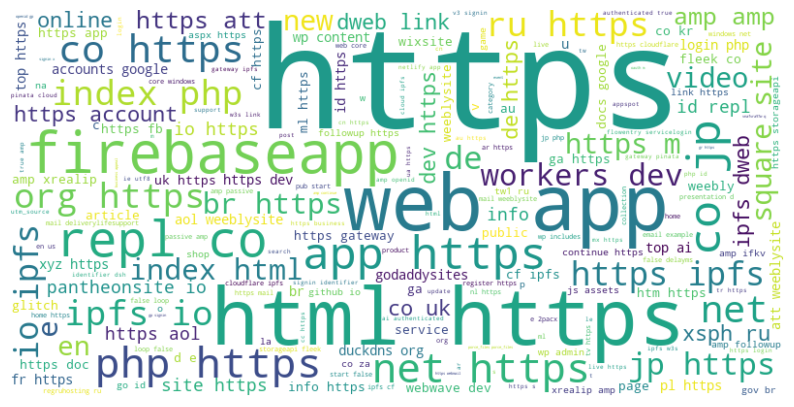

In [168]:
urls = " ".join(data['url'])

word_cloud = WordCloud(width=800,height=400,background_color='white').generate(urls)

plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

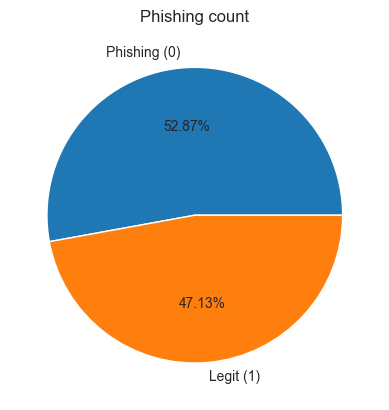

In [169]:
counts = data['label'].value_counts()
counts = counts.rename(index={0: 'Phishing (0)', 1: 'Legit (1)'})
counts.plot(kind='pie', autopct='%1.2f%%')
plt.title("Phishing count")
plt.ylabel('')
plt.show()

In [170]:
X_train_df, X_test_df = train_test_split(data, test_size=0.2, stratify=data["label"], random_state=42)
X_train_df, X_val_df  = train_test_split(X_train_df, test_size=0.2, stratify=X_train_df["label"], random_state=42)

y_train = X_train_df["label"].astype("int32").to_numpy()
y_val   = X_val_df["label"].astype("int32").to_numpy()
y_test  = X_test_df["label"].astype("int32").to_numpy()

X_train_str = X_train_df["url"].astype(str).to_numpy()
X_val_str   = X_val_df["url"].astype(str).to_numpy()
X_test_str  = X_test_df["url"].astype(str).to_numpy()

#### Convert URLs in Char-Indices and build Lookup Vocabulary

In [171]:
# set sequence length to training data (e.g. 95th percentile, min 8)
train_lengths = np.array([len(u) for u in X_train_str], dtype=np.int32)
MAX_LEN = max(8, int(np.percentile(train_lengths, 95)))
print(MAX_LEN)

109


In [172]:
# adapt StringLookup vocabulary to TRAIN only:
train_text_ds = tf.data.Dataset.from_tensor_slices(X_train_str).batch(1024)
char_ds = train_text_ds.map(lambda batch: tf.strings.unicode_split(batch, "UTF-8"))  # Ragged[str] pro Batch

In [173]:
# StringLookup:
# - mask_token="" -> Index 0 is reserved for padding
# - oov_token="[UNK]" -> Unknown characters are placed in the OOV bucket
lookup = layers.StringLookup(
    mask_token="",
    oov_token="[UNK]",
    num_oov_indices=1,
    output_mode="int",
    name="char_lookup",
)
lookup.adapt(char_ds)
VOCAB_SIZE = lookup.vocabulary_size()
print(VOCAB_SIZE)

1596


In [174]:
# input: raw url-string
inp = layers.Input(shape=(), dtype=tf.string, name="input_url_str")

# split unicode into chars
chars = layers.Lambda(lambda x: tf.strings.unicode_split(x, "UTF-8"),
                      name="unicode_split", output_shape=(None,))(inp)

# convert chars into indices (PAD = Index:0, OVV = Index:1)
idx_rt = lookup(chars)

# Ragged[int] -> Dense[int] with fixed length and PAD=0
idx = layers.Lambda(
    lambda rt: rt.to_tensor(
        default_value=tf.cast(0, rt.dtype),
        shape=[tf.shape(rt)[0], MAX_LEN]
    ),
    name="pad_to_max_len",
    output_shape=(MAX_LEN,)
)(idx_rt)

#### Train Convolutional Neural Network (CNN)

In [175]:
# Embedding
x = layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=64,
    name="embedding"
)(idx)

# Dropout
x = layers.Dropout(rate=0.2, name="Dropout")(x)

# Explicitly zero PAD positions to 0 (feature vectors there = 0)
pad_mask = layers.Lambda(
    lambda t: tf.cast(tf.not_equal(t, 0), x.dtype),
    name="pad_mask"
)(idx)
pad_mask = layers.Lambda(lambda m: tf.expand_dims(m, -1), name="pad_mask_expand")(pad_mask)
x = layers.Multiply(name="apply_pad_mask")([x, pad_mask])

# Conv1D
x = layers.Conv1D(
    filters=64,
    kernel_size=5,
    activation="relu",
    use_bias=False,
    name="Conv1D"
)(x)

# MaxPooling1D
x = layers.MaxPooling1D(pool_size=4, name="MaxPooling1D")(x)

# GlobalMaxPooling1D
x = layers.GlobalMaxPooling1D(name="GlobalMaxPooling1D")(x)

# Dense
out = layers.Dense(units=2, activation="softmax", name="Dense_Output")(x)

# build model
cnn_model = models.Model(inp, out, name="cnn_phishing_urls")

# compile
cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Early Stopping
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
)

In [176]:
# Training
history_cnn = cnn_model.fit(
    X_train_str,
    y_train,
    validation_data=(X_val_str, y_val),
    epochs=30,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8319 - loss: 0.3663 - val_accuracy: 0.9324 - val_loss: 0.1729
Epoch 2/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9307 - loss: 0.1772 - val_accuracy: 0.9397 - val_loss: 0.1590
Epoch 3/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9397 - loss: 0.1550 - val_accuracy: 0.9491 - val_loss: 0.1356
Epoch 4/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9458 - loss: 0.1398 - val_accuracy: 0.9528 - val_loss: 0.1254
Epoch 5/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9493 - loss: 0.1328 - val_accuracy: 0.9536 - val_loss: 0.1233
Epoch 6/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9524 - loss: 0.1230 - val_accuracy: 0.9524 - val_loss: 0.1320
Epoch 7/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9544 - loss: 0.1206 - val_accuracy: 0.9564 - val_loss: 0.1154
Epoch 8/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9552 - loss: 0.1166 - val_

In [177]:
y_proba_train_cnn = cnn_model.predict(X_train_str)
y_pred_train_cnn = np.argmax(y_proba_train_cnn, axis=1)

y_proba_test_cnn = cnn_model.predict(X_test_str)
y_pred_test_cnn  = np.argmax(y_proba_test_cnn, axis=1)

cnn_model.save("../models/dl/cnn.keras")

3819/3819 ━━━━━━━━━━━━━━━━━━━━ 4s 936us/step
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step


In [178]:
acc_train_cnn = metrics.accuracy_score(y_train, y_pred_train_cnn)
acc_test_cnn = metrics.accuracy_score(y_test, y_pred_test_cnn)
print("CNN : Accuracy on training Data: {:.4f}".format(acc_train_cnn))
print("CNN : Accuracy on test Data: {:.4f}".format(acc_test_cnn))

CNN : Accuracy on training Data: 0.9750
CNN : Accuracy on test Data: 0.9637


In [179]:
print("Training Data:")
print(metrics.classification_report(y_train, y_pred_train_cnn, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Training Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9884    0.9640    0.9760     64604
    Legit(1)     0.9607    0.9873    0.9738     57600

    accuracy                         0.9750    122204
   macro avg     0.9745    0.9756    0.9749    122204
weighted avg     0.9753    0.9750    0.9750    122204



In [180]:
print("Testing Data:")
print(metrics.classification_report(y_test, y_pred_test_cnn, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Testing Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9767    0.9540    0.9652     20189
    Legit(1)     0.9497    0.9745    0.9619     18000

    accuracy                         0.9637     38189
   macro avg     0.9632    0.9642    0.9636     38189
weighted avg     0.9640    0.9637    0.9637     38189



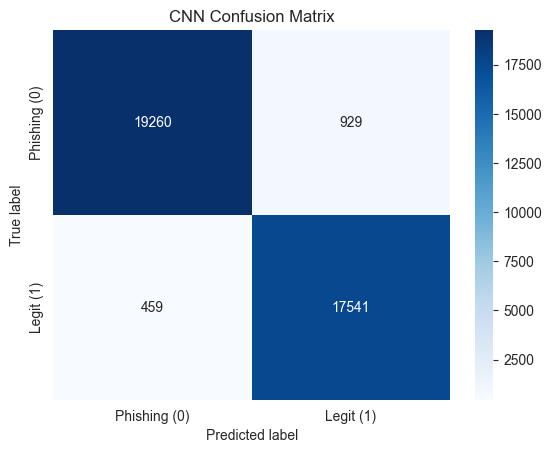

In [181]:
cnn_conf_matrix = metrics.confusion_matrix(y_test, y_pred_test_cnn)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(cnn_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('CNN Confusion Matrix')
plt.show()

#### Train Convolutional Neural Network - Long Short-Term Memory (CNN-LSTM)

In [182]:
# Embedding
x = layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=64,
    name="embedding"
)(idx)

# Dropout
x = layers.Dropout(0.2, name="dropout")(x)

# Explicitly zero PAD positions to 0 (feature vectors there = 0)
pad_mask = layers.Lambda(
    lambda t: tf.cast(tf.not_equal(t, 0), x.dtype),
    name="pad_mask"
)(idx)
pad_mask = layers.Lambda(lambda m: tf.expand_dims(m, -1), name="pad_mask_expand")(pad_mask)
x = layers.Multiply(name="apply_pad_mask")([x, pad_mask])

# Conv1D
x = layers.Conv1D(
    filters=64,
    kernel_size=5,
    activation="relu",
    use_bias=False,
    name="Conv1D"
)(x)

# MaxPooling1D
x = layers.MaxPooling1D(pool_size=4, name="MaxPooling1D")(x)

# LSTM
x = layers.LSTM(64, name="lstm")(x)

# Dense
out = layers.Dense(units=2, activation="softmax", name="Dense_Output")(x)

# build model
cnn_lstm_model = models.Model(inp, out, name="lstm_phishing_urls")

# compile
cnn_lstm_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Early Stopping
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
)

In [183]:
# Training
history_lstm = cnn_lstm_model.fit(
    X_train_str,
    y_train,
    validation_data=(X_val_str, y_val),
    epochs=30,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8359 - loss: 0.3368 - val_accuracy: 0.9454 - val_loss: 0.1418
Epoch 2/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9395 - loss: 0.1526 - val_accuracy: 0.9439 - val_loss: 0.1448
Epoch 3/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9520 - loss: 0.1240 - val_accuracy: 0.9599 - val_loss: 0.1066
Epoch 4/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9572 - loss: 0.1107 - val_accuracy: 0.9555 - val_loss: 0.1211
Epoch 5/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9580 - loss: 0.1099 - val_accuracy: 0.9636 - val_loss: 0.0973
Epoch 6/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9621 - loss: 0.0993 - val_accuracy: 0.9583 - val_loss: 0.1093
Epoch 7/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9631 - loss: 0.0960 - val_accuracy: 0.9647 - val_loss: 0.0939
Epoch 8/30
955/955 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9651 - loss: 0.0908 - 

In [184]:
y_proba_train_lstm = cnn_lstm_model.predict(X_train_str)
y_pred_train_lstm = np.argmax(y_proba_train_lstm, axis=1)

y_proba_test_lstm = cnn_lstm_model.predict(X_test_str)
y_pred_test_lstm  = np.argmax(y_proba_test_lstm, axis=1)

cnn_lstm_model.save("../models/dl/cnn-lstm.keras")

3819/3819 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [185]:
acc_train_lstm = metrics.accuracy_score(y_train, y_pred_train_lstm)
acc_test_lstm = metrics.accuracy_score(y_test, y_pred_test_lstm)
print("CNN-LSTM : Accuracy on training Data: {:.4f}".format(acc_train_lstm))
print("CNN-LSTM : Accuracy on test Data: {:.4f}".format(acc_test_lstm))

CNN-LSTM : Accuracy on training Data: 0.9825
CNN-LSTM : Accuracy on test Data: 0.9715


In [186]:
print("Training Data:")
print(metrics.classification_report(y_train, y_pred_train_lstm, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Training Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9945    0.9723    0.9833     64604
    Legit(1)     0.9697    0.9939    0.9817     57600

    accuracy                         0.9825    122204
   macro avg     0.9821    0.9831    0.9825    122204
weighted avg     0.9828    0.9825    0.9825    122204



In [187]:
print("Testing Data:")
print(metrics.classification_report(y_test, y_pred_test_lstm, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Testing Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9856    0.9600    0.9727     20189
    Legit(1)     0.9564    0.9843    0.9702     18000

    accuracy                         0.9715     38189
   macro avg     0.9710    0.9722    0.9714     38189
weighted avg     0.9719    0.9715    0.9715     38189



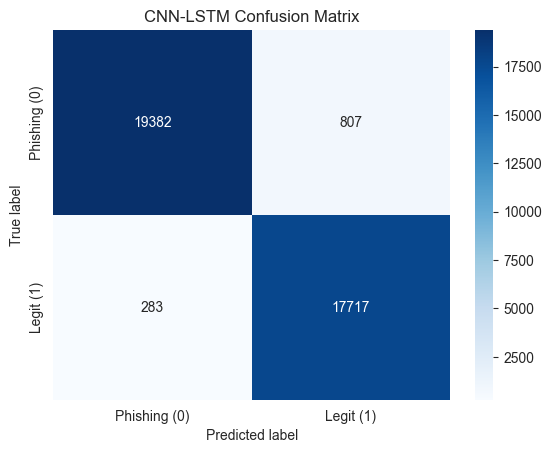

In [188]:
cnn_lstm_conf_matrix = metrics.confusion_matrix(y_test, y_pred_test_lstm)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(cnn_lstm_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('CNN-LSTM Confusion Matrix')
plt.show()

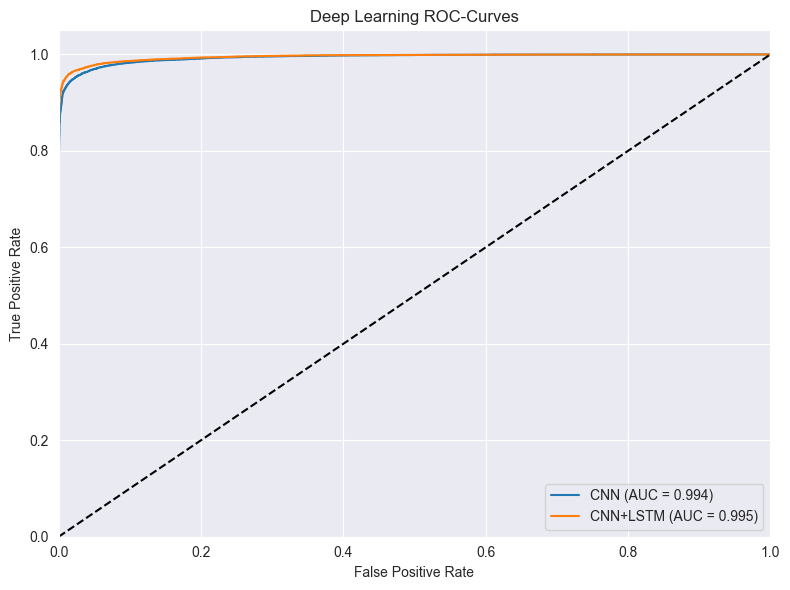

In [189]:
dl_models = {
    "CNN": cnn_model,
    "CNN+LSTM": cnn_lstm_model,
}

def get_phishing_scores_from_keras(model, X):
    y_pred = model.predict(X, verbose=0)

    if y_pred.ndim == 1 or y_pred.shape[1] == 1:
        p_legit = y_pred.ravel()
        p_phishing = 1.0 - p_legit
    else:
        p_phishing = y_pred[:, 0]

    return p_phishing

y_true_phishing = (y_test == 0).astype(int)

plt.figure(figsize=(8, 6))

for name, model in dl_models.items():
    y_score = get_phishing_scores_from_keras(model, X_test_str)
    fpr, tpr, _ = roc_curve(y_true_phishing, y_score)
    auc = roc_auc_score(y_true_phishing, y_score)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Deep Learning ROC-Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Evaluation

#### Load and visualize Evaluation Data

In [190]:
eval_data = pd.read_csv("../data/evaluation/evaluation-features.csv")
eval_data = eval_data[["url", "label"]]
eval_data.head()

,url,label
0,http://4aoo-bmmanager045288.vercel.app/?naps,0
1,http://0suz-bmmanager047181.vercel.app/?naps,0
2,http://ncrm-casefb588197.vercel.app/?naps,0
3,http://casefb668303-f2w6.vercel.app/?naps,0
4,http://casefb480777-qhn9.vercel.app/?naps,0


In [191]:
eval_data.columns

Index(['url', 'label'], dtype='object')

In [192]:
eval_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54270 entries, 0 to 54269
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     54270 non-null  object
 1   label   54270 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 848.1+ KB


In [193]:
eval_data.nunique()

url      54270
label        2
dtype: int64

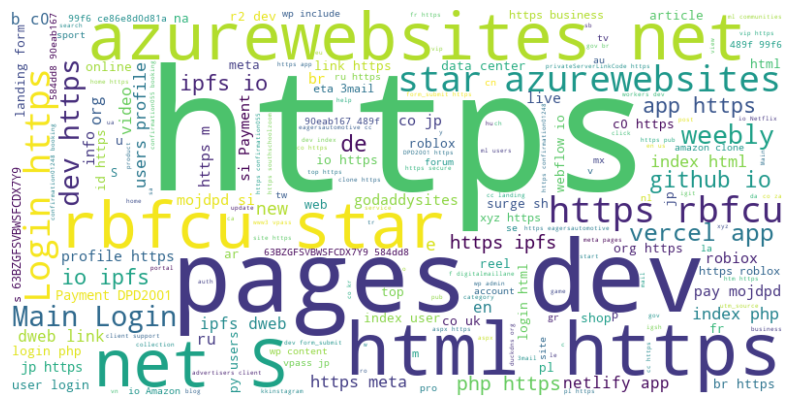

In [194]:
urls = " ".join(eval_data['url'])

word_cloud = WordCloud(width=800,height=400,background_color='white').generate(urls)

plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

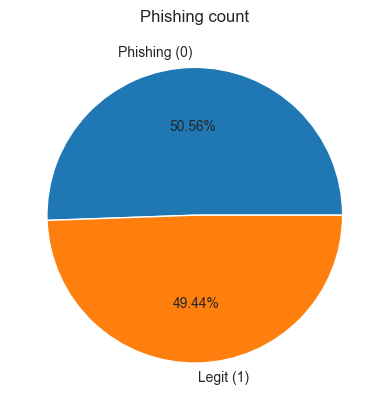

In [195]:
counts = eval_data['label'].value_counts()
counts = counts.rename(index={0: 'Phishing (0)', 1: 'Legit (1)'})
counts.plot(kind='pie', autopct='%1.2f%%')
plt.title("Phishing count")
plt.ylabel('')
plt.show()

In [196]:
y_eval = eval_data["label"].astype("int32").to_numpy()
X_eval_str = eval_data["url"].astype(str).to_numpy()

#### Evaluate Convolutional Neural Network (CNN)

In [197]:
y_proba_eval_cnn = cnn_model.predict(X_eval_str, batch_size=128, verbose=1)
y_pred_eval_cnn  = np.argmax(y_proba_eval_cnn, axis=1)

424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [198]:
acc_train_cnn = metrics.accuracy_score(y_eval, y_pred_eval_cnn)
print("CNN : Accuracy on evaluation Data: {:.4f}".format(acc_train_cnn))

CNN : Accuracy on evaluation Data: 0.7786


In [199]:
print(metrics.classification_report(y_eval, y_pred_eval_cnn, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

              precision    recall  f1-score   support

 Phishing(0)     0.9621    0.5851    0.7277     27439
    Legit(1)     0.6971    0.9764    0.8135     26831

    accuracy                         0.7786     54270
   macro avg     0.8296    0.7808    0.7706     54270
weighted avg     0.8311    0.7786    0.7701     54270



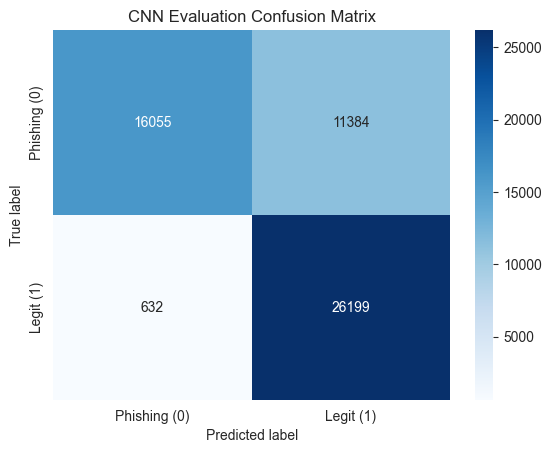

In [200]:
cnn_eval_conf_matrix = metrics.confusion_matrix(y_eval, y_pred_eval_cnn)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(cnn_eval_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('CNN Evaluation Confusion Matrix')
plt.show()

#### Evaluate Convolutional Neural Network - Long Short-Term Memory (CNN-LSTM)

In [201]:
y_proba_eval_cnn_lstm = cnn_lstm_model.predict(X_eval_str, batch_size=128, verbose=1)
y_pred_eval_cnn_lstm  = np.argmax(y_proba_eval_cnn_lstm, axis=1)

424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [202]:
acc_train_cnn_lstm = metrics.accuracy_score(y_eval, y_pred_eval_cnn_lstm)
print("CNN-LSTM : Accuracy on evaluation Data: {:.4f}".format(acc_train_cnn_lstm))

CNN-LSTM : Accuracy on evaluation Data: 0.8019


In [203]:
print(metrics.classification_report(y_eval, y_pred_eval_cnn_lstm, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

              precision    recall  f1-score   support

 Phishing(0)     0.9774    0.6227    0.7607     27439
    Legit(1)     0.7186    0.9853    0.8310     26831

    accuracy                         0.8019     54270
   macro avg     0.8480    0.8040    0.7959     54270
weighted avg     0.8494    0.8019    0.7955     54270



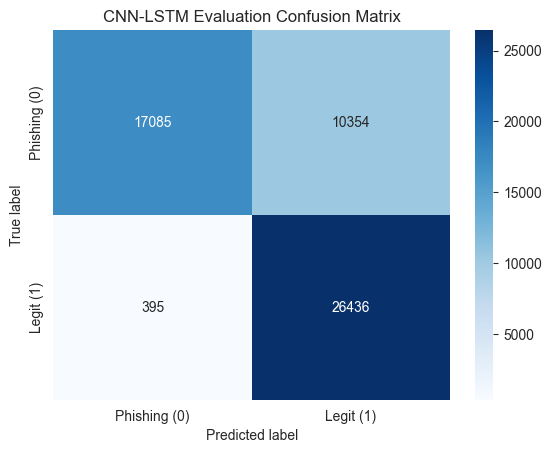

In [204]:
cnn_lstm_eval_conf_matrix = metrics.confusion_matrix(y_eval, y_pred_eval_cnn_lstm)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(cnn_lstm_eval_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('CNN-LSTM Evaluation Confusion Matrix')
plt.show()

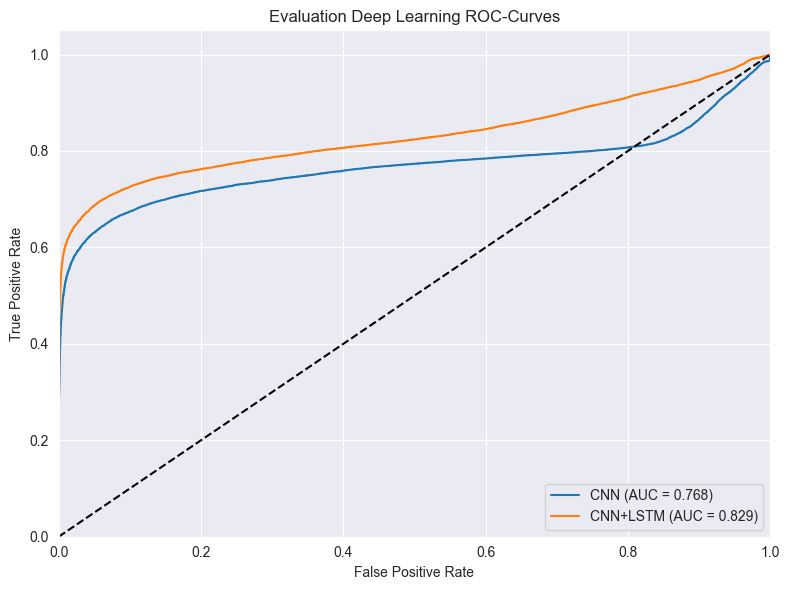

In [205]:
dl_models = {
    "CNN": cnn_model,
    "CNN+LSTM": cnn_lstm_model,
}

def get_phishing_scores_from_keras(model, X):
    y_pred = model.predict(X, verbose=0)

    if y_pred.ndim == 1 or y_pred.shape[1] == 1:
        p_legit = y_pred.ravel()
        p_phishing = 1.0 - p_legit
    else:
        p_phishing = y_pred[:, 0]

    return p_phishing

y_true_phishing = (y_eval == 0).astype(int)

plt.figure(figsize=(8, 6))

for name, model in dl_models.items():
    y_score = get_phishing_scores_from_keras(model, X_eval_str)
    fpr, tpr, _ = roc_curve(y_true_phishing, y_score)
    auc = roc_auc_score(y_true_phishing, y_score)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Evaluation Deep Learning ROC-Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()